In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pathlib
import seaborn as sns
import datetime
from scipy import signal, fftpack
# import cv2

from dateutil.relativedelta import relativedelta
import plotly.graph_objects as go
import plotly.io as pio

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def df_birth_no_geo_prep(df, filter_year=None):
    
    # load csv is like this...
    # df = pd.read_csv(data_file, dtype=int).sort_values(by=['dob_yy', 'dob_mm', 'dob_wk'])
    
    # helper functions
    def get_month_string(cols):
        month_index = int(cols[0])

        # from https://stackoverflow.com/a/28446432/9214620
        return datetime.date(1900, month_index, 1).strftime('%B')

    def get_conception_month(cols):
        month_index = int(cols[0])
        concept_date = datetime.date(1900, month_index, 1) + relativedelta(months=-9)

        return concept_date.strftime('%B')
    
    def get_conception_year(cols):
        month_index = int(cols[0])
        year = int(cols[1])
        concept_date = datetime.date(year, month_index, 1) + relativedelta(months=-9)

        return int(concept_date.strftime('%Y'))

    def get_conception_month_index(cols):
        month_index = int(cols[0])
        concept_date = datetime.date(1900, month_index, 1) + relativedelta(months=-9)

        return int(concept_date.strftime('%m'))
    
    # add conception month columns and birth month
    df['conc_month'] = df[['dob_mm']].apply(get_conception_month, axis=1)
    df['birth_month'] = df[['dob_mm']].apply(get_month_string, axis=1)
    df['conc_mm'] = df[['dob_mm']].apply(get_conception_month_index, axis=1)
    df['conc_yy'] = df[['dob_mm', 'dob_yy']].apply(get_conception_year, axis=1)
    df = df.sort_values(by=['conc_yy', 'conc_mm'])
    

    return df[['conc_yy','conc_month','dob_yy', 'birth_month', 'conc_mm', 'dob_mm', 'births']]

In [13]:
# load the data

data_folder = Path('./data/processed')

data_file = data_folder / 'birth_no_geo.csv'

# create unfiltered df
df = pd.read_csv(data_file, dtype=int)
df = df_birth_no_geo_prep(df)
df = df.sort_values(by=['dob_yy', 'dob_mm'])
df.head()

,conc_yy,conc_month,dob_yy,birth_month,conc_mm,dob_mm,births
108,1967,April,1968,January,4,1,138702
112,1967,May,1968,February,5,2,133041
113,1967,June,1968,March,6,3,141076
114,1967,July,1968,April,7,4,136782
115,1967,August,1968,May,8,5,144234


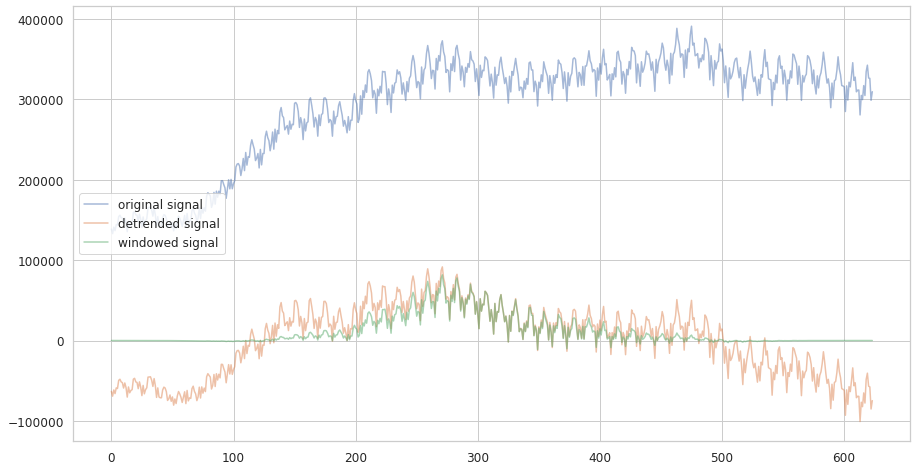

In [34]:
# practice detrending
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

plt.plot(df['births'].values, alpha=0.5, label='original signal')
y_detrend = signal.detrend(df['births'].values, type="linear")
plt.plot(y_detrend, alpha=0.5, label='detrended signal')

# apply either a hamming or kaiser windowing function
# y_detrend *= np.hamming(len(y_detrend))
y_detrend *= np.kaiser(len(y_detrend), 14)
plt.plot(y_detrend, alpha=0.5, label='windowed signal')
plt.legend(loc='center left')

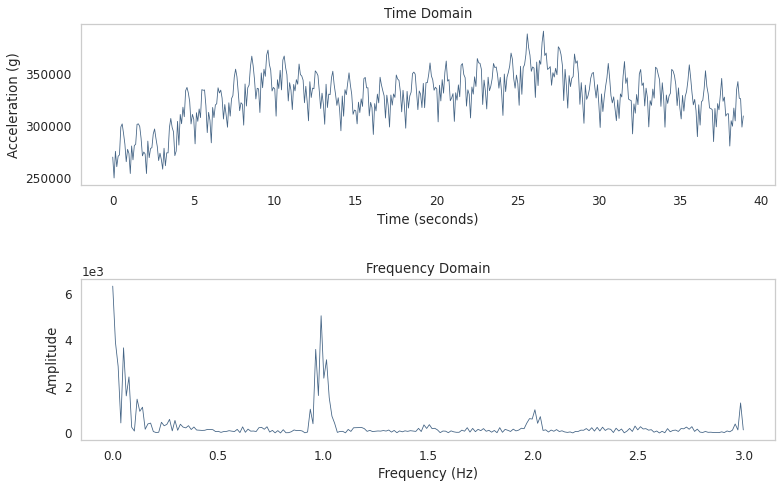

In [39]:
def create_fft(df, x_name='Time', y_name='births', sample_freq=1.0, show_plot=True, window='kaiser', beta=3):
    '''Create FFT plot from a pandas dataframe'''

    y = df[y_name].to_numpy(dtype="float64")  # convert to a numpy array
    x = np.arange(0,df.shape[0], dtype='float64') / (sample_freq)

    # parameters for plot
    T = 1.0 / sample_freq  # sample spacing
    N = len(y)  # number of sample points
    
    # do some preprocessing of the current signal
    y_detrend = y - np.mean(y)
    y_detrend = signal.detrend(y_detrend, type="constant")  # detrended signal
    
    if window == 'hamming':
        y_detrend *= np.hamming(N)  # apply a hamming window. Why? https://dsp.stackexchange.com/a/11323
    else:
        y_detrend *= np.kaiser(len(y_detrend), beta)

    # FFT on time domain signal
    yf = fftpack.rfft(y_detrend)
    yf = 2.0 / N * np.abs(yf[: int(N / 2.0)])
    xf = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)/2

    if show_plot:
        # setup the seaborn plot
        sns.set(font_scale=1.1, style="whitegrid")
        fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False, sharey=False)
        fig.tight_layout(pad=5.0)

        pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)  # pick nice color for plot

        # plot time domain signal
        axes[0].plot(x, y, marker="", label="Best model", color=pal[3], linewidth=0.8)
        axes[0].set_title("Time Domain", fontdict={"fontweight": "normal"})
        axes[0].set_xlabel("Time (seconds)")
        axes[0].set_ylabel("Acceleration (g)")
        # axes[0].set_yticklabels([])

        # plot the frequency domain signal
        axes[1].plot(xf, yf, marker="", label="Best model", color=pal[3], linewidth=0.8)
        axes[1].set_title("Frequency Domain", fontdict={"fontweight": "normal"})
        axes[1].set_xlabel("Frequency (Hz)")
        axes[1].set_ylabel("Amplitude")
        plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        

        # clean up the sub-plots to make everything pretty
        for ax in axes.flatten():
            ax.yaxis.set_tick_params(labelleft=True, which="major")
            ax.grid(False)
            
        # in case you want to save the figure (just uncomment)
#         plt.savefig('time_freq_domains.svg', format='svg', dpi=300,bbox_inches = "tight")
        plt.savefig('time_freq_domains.png', format='png', dpi=300,bbox_inches = "tight")
        plt.show()
    
    return xf, yf

xf, yf = create_fft(df[df['dob_yy']>1980], x_name='Time', y_name='births', 
                    sample_freq=12, show_plot=True, window='kaiser', beta=12)